In [378]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    IN_COLAB = True
except:
    IN_COLAB = False

In [379]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import time

In [380]:
pd.set_option("display.width", 10000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", None)

TESTING = True
TESTING_SIZE = 0.01
BENCMARK_ITER_N = 10
random_state = 245

benchmark_results = pd.DataFrame(
    columns=[
        "Model",
        "Dataset",
        "Info",
        "Data size",
        "Accuracy",
        "Precision",
        "Recall",
        "F1",
        "Time per data per iter",
    ]
)


def benchmarkAndUpdateResult(df, model, model_name, dataset_name, info, pipeline_fn, **pipeline_kwargs):
    global benchmark_results
    df_ = pipeline_fn(df=df, **pipeline_kwargs)
    X = df_[df_.columns[:-1]]
    y = df_[df_.columns[-1]]
    data_size = np.shape(X)[0]
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    iter_n = BENCMARK_ITER_N
    start = time.perf_counter_ns()
    for _ in range(iter_n):  # benchmark
        df_ = pipeline_fn(df=df, **pipeline_kwargs)
        X = df_[df_.columns[:-1]]
        model.predict(X)
    end = time.perf_counter_ns()
    time_per_data_per_iter = (end - start) / data_size / iter_n
    benchmark_results.loc[len(benchmark_results)] = [
        model_name,
        dataset_name,
        info,
        data_size,
        accuracy,
        precision,
        recall,
        f1,
        time_per_data_per_iter,
    ]
    print(classification_report(y, y_pred))
    print()
    print(f"Model: {model_name}")
    print(f"Data size: {data_size}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1: {f1}")
    print(f"Time per data per iter: {time_per_data_per_iter}")

In [381]:
def test_train_val_split(df, random_state=random_state):
    X_train, X_tmp, y_train, y_tmp = train_test_split(
        df.iloc[:, :-1], df.iloc[:, -1], test_size=0.3, random_state=random_state
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=random_state
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [382]:
if IN_COLAB:
    prepend_path = (
        "/content/drive/MyDrive/Syncable/sjsu/data-245/DATA 245 Project Files/data"
    )
else:
    prepend_path = "./data"
known_attacks_path = f"{prepend_path}/probe_known_attacks_small.csv"
similar_attacks_path = f"{prepend_path}/probe_similar_attacks_small.csv"
new_attacks_path = f"{prepend_path}/probe_new_attacks_small.csv"

In [383]:
df = pd.read_csv(known_attacks_path, low_memory=False)

In [384]:
if TESTING:
    df = df.sample(frac=TESTING_SIZE, random_state=random_state)
    df.reset_index(drop=True, inplace=True)
df.shape

(851, 51)

In [385]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_offset', 'ip_RF', 'ip_DF', 'ip_MF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [386]:
df.head()

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,0,90,0,0,0,1,0,17,47118,46978,161,70,36224,0,0,0,0,0,0,0,2,2,2,2,2,2,62,12,1004,1155,843,843,54460,103031,52399,53498,1,0,0,0,1,1,160,312,1,1,0,0,0,0,normal
1,0,74,0,0,0,1,0,17,47134,39806,161,54,40008,0,0,0,0,0,0,0,2,2,2,2,2,2,46,12,628,736,189,188,27369,133907,8733,9892,2,0,0,0,2,2,189,300,2,2,0,0,0,0,normal
2,0,52,60702,0,0,1,0,6,52022,0,0,0,0,0,0,0,38686,80,1465446369,229426048,0,0,0,0,1,0,12,6,259,389,150,238,3366,168446,1929,102911,2,0,0,0,16,1,257,389,2,2,0,0,0,0,normal
3,0,40,3309,0,0,0,0,6,62806,0,0,0,0,0,0,0,43694,38292,2144613666,0,1,0,0,0,0,0,6,1,5,4,5,4,30,0,30,0,0,0,0,0,5,0,0,4,0,0,0,4,0,0,attack
4,0,552,32493,0,0,0,0,6,30593,0,0,0,0,0,0,0,80,46765,4269299949,2394833563,0,0,0,0,1,0,512,6,283,494,262,471,8985,65836,3273,65535,9,0,0,0,2,2,280,494,3,3,0,0,0,0,normal


In [387]:
df.describe(include="all")

,ip_type,ip_len,ip_id,ip_offset,ip_RF,ip_DF,ip_MF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
count,851.000000,851.000000,851.000000,851.0,851.0,851.000000,851.0,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,8.510000e+02,8.510000e+02,851.000000,851.000000,851.000000,851.000000,851.00000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501
mean,0.705053,104.905993,31592.650999,0.0,0.0,0.377203,0.0,8.175088,33998.130435,7476.284371,4915.646298,8.826087,6484.471210,0.077556,0.052879,617.799060,27103.504113,12732.139835,1.467903e+09,1.001886e+09,0.584019,0.586369,0.551116,0.518214,0.93067,0.505288,70.525264,5.996475,431.565217,510.766157,269.860165,330.781434,10400.117509,28350.108108,8353.157462,17188.714454,72.913043,9.130435,30.186839,49.016451,84.316099,0.815511,119.443008,245.368978,80.353702,3.757932,2.145711,120.836663,0.004700,0.088132,NaN
std,5.266651,204.980678,19634.151234,0.0,0.0,0.484971,0.0,4.562625,18655.324009,17974.856746,14118.453369,22.389132,15073.508858,0.653391,0.394999,4383.992034,24457.322752,20285.670627,1.445902e+09,1.372752e+09,0.835071,0.834831,0.837733,0.839095,0.72022,0.839276,203.580168,4.215516,1695.161318,910.229657,421.443629,2277.916525,17246.190024,40717.777331,17373.816503,28514.547351,1517.815469,265.357913,252.971529,446.370263,1140.237955,9.725409,306.468887,399.752653,279.890438,58.340221,17.307324,255.945091,0.068438,0.283653,NaN
min,0.000000,28.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,0.000000,40.000000,15144.000000,0.0,0.0,0.000000,0.0,6.000000,18496.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,80.000000,31.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,6.000000,2.000000,26.000000,24.000000,5.000000,2.000000,709.500000,18.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,0.000000,52.000000,31748.000000,0.0,0.0,0.000000,0.0,6.000000,34574.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34757.000000,711.000000,1.118637e+09,0.000000e+00,0.000000,0.000000,

It seems as though ip_RF, ip_MF, and ip_offset do not contain any valuable information. They can be removed

In [388]:
df = df.drop(columns=["ip_RF", "ip_MF", "ip_offset"])

In [389]:
df.columns

Index(['ip_type', 'ip_len', 'ip_id', 'ip_DF', 'ip_proto', 'ip_checksum', 'udp_sport', 'udp_dport', 'udp_len', 'udp_chk', 'icmp_type', 'icmp_code', 'icmp_chk', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_frst', 'tcp_fpush', 'tcp_fack', 'tcp_furg', 'fr_length', 'conn_status', 'count_fr_src_dst', 'count_fr_dst_src', 'count_serv_src_dst', 'count_serv_dst_src', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_pushed_src_dst', 'num_pushed_dst_src', 'num_syn_fin_src_dst', 'num_syn_fin_dst_src', 'num_fin_src_dst', 'num_fin_dst_src', 'num_ack_src_dst', 'num_ack_dst_src', 'num_syn_src_dst', 'num_syn_dst_src', 'num_rst_src_dst', 'num_rst_dst_src', 'first_packet', 'first_serv_packet', 'class'], dtype='object')

In [390]:
print(df["class"].value_counts())
print(df["class"].value_counts(normalize=True) * 100)

class
normal    501
attack    350
Name: count, dtype: int64
class
normal    58.871915
attack    41.128085
Name: proportion, dtype: float64


In [391]:
df.dtypes

ip_type                    int64
ip_len                     int64
ip_id                      int64
ip_DF                      int64
ip_proto                   int64
ip_checksum                int64
udp_sport                  int64
udp_dport                  int64
udp_len                    int64
udp_chk                    int64
icmp_type                  int64
icmp_code                  int64
icmp_chk                   int64
tcp_sport                  int64
tcp_dport                  int64
tcp_seq                    int64
tcp_ack                    int64
tcp_ffyn                   int64
tcp_fsyn                   int64
tcp_frst                   int64
tcp_fpush                  int64
tcp_fack                   int64
tcp_furg                   int64
fr_length                  int64
conn_status                int64
count_fr_src_dst           int64
count_fr_dst_src           int64
count_serv_src_dst         int64
count_serv_dst_src         int64
num_bytes_src_dst          int64
num_bytes_

In [392]:
df["ip_type"].value_counts()

ip_type
0     836
40     15
Name: count, dtype: int64

In [393]:
df["class"] = df["class"].replace({"normal": 0, "attack": 1})

In [394]:
df = df.astype(float)

In [395]:
corr = df.corr()

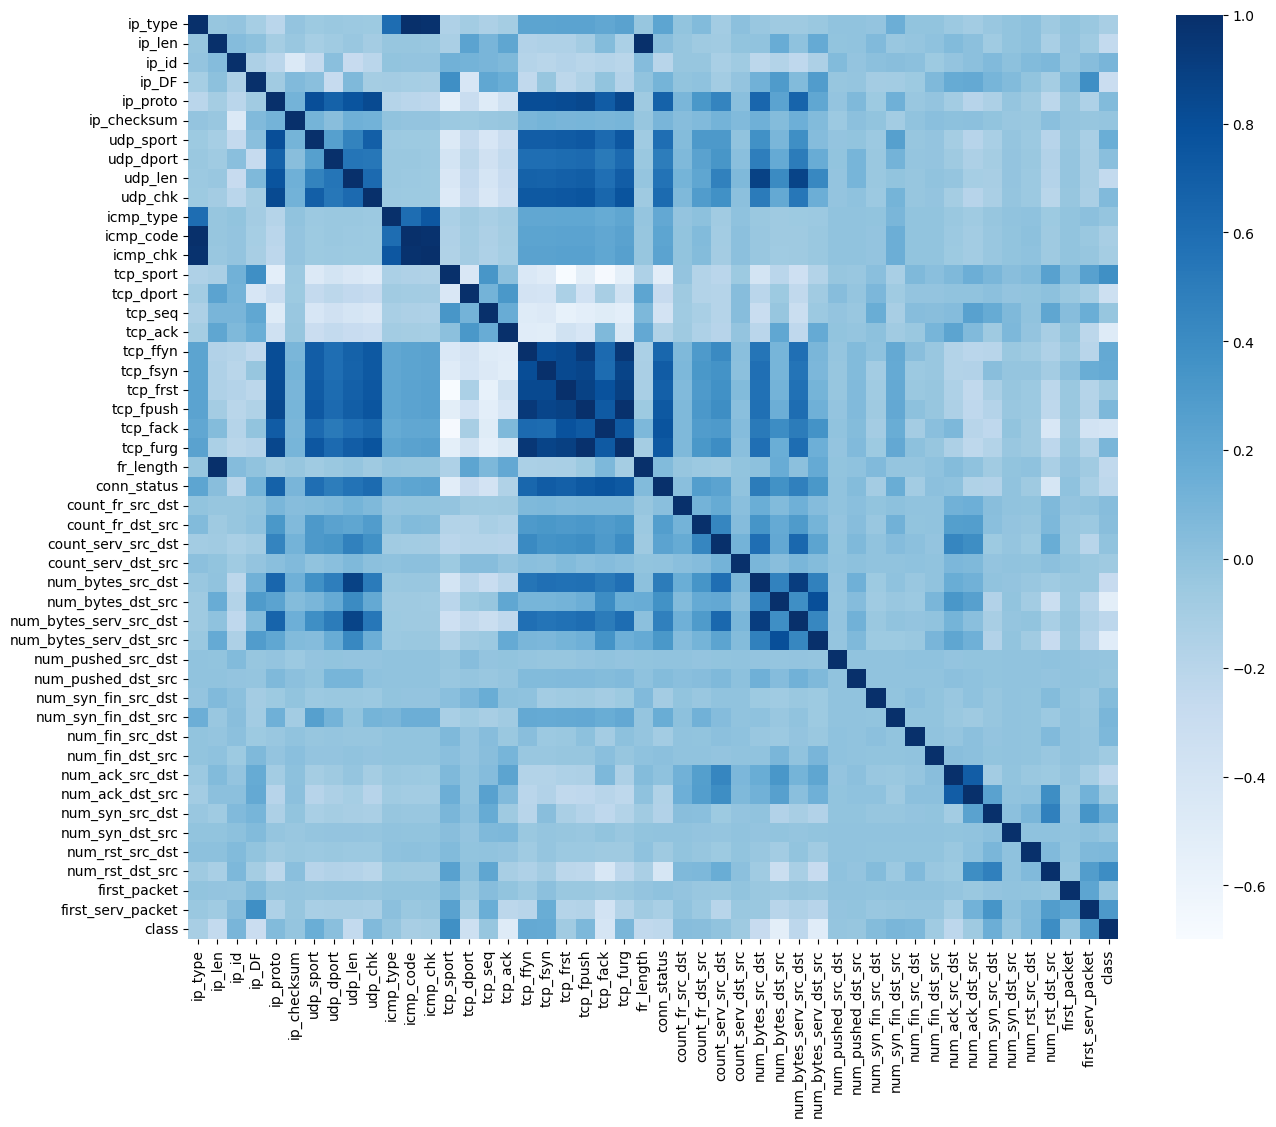

In [396]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr, cmap="Blues")
plt.show()

In [397]:
corr["class"].sort_values(ascending=False)

class                     1.000000
num_rst_dst_src           0.392762
tcp_sport                 0.376274
first_serv_packet         0.304559
tcp_ffyn                  0.184828
tcp_fsyn                  0.179664
udp_sport                 0.157443
num_syn_src_dst           0.149411
ip_id                     0.093967
tcp_furg                  0.088684
num_syn_fin_dst_src       0.085416
num_rst_src_dst           0.077591
num_fin_src_dst           0.077263
tcp_fpush                 0.075820
udp_chk                   0.064631
ip_proto                  0.056937
num_syn_fin_src_dst       0.047659
count_fr_src_dst          0.038038
count_fr_dst_src          0.026416
udp_dport                 0.021531
count_serv_src_dst       -0.001497
icmp_type                -0.022471
first_packet             -0.022524
num_pushed_src_dst       -0.024347
num_syn_dst_src          -0.026552
ip_checksum              -0.027072
num_pushed_dst_src       -0.028776
tcp_seq                  -0.029051
count_serv_dst_src  

The target feature does not seem to have very strong correlations with any particular feature.

In [398]:
# remove all features with an absolute correlation of less than 0.1
cols_corr_gt1 = corr["class"][abs(corr["class"]) > 0.1].index

In [399]:
print(cols_corr_gt1)
print(len(cols_corr_gt1))

Index(['ip_type', 'ip_len', 'ip_DF', 'udp_sport', 'udp_len', 'icmp_code', 'tcp_sport', 'tcp_dport', 'tcp_ack', 'tcp_ffyn', 'tcp_fsyn', 'tcp_fack', 'fr_length', 'conn_status', 'num_bytes_src_dst', 'num_bytes_dst_src', 'num_bytes_serv_src_dst', 'num_bytes_serv_dst_src', 'num_ack_src_dst', 'num_syn_src_dst', 'num_rst_dst_src', 'first_serv_packet', 'class'], dtype='object')
23


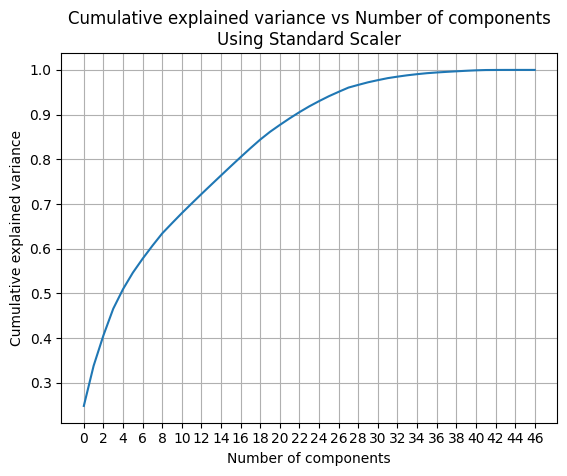

In [400]:
X = df.drop(columns=["class"])

scaler_standard = StandardScaler()
X_scaled = scaler_standard.fit_transform(X)

pca_standard = PCA(n_components=len(df.columns) - 1)
X_pca = pca_standard.fit_transform(X_scaled)

pca_cumsum = pca_standard.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components\nUsing Standard Scaler")
plt.grid()
plt.xticks(range(0, len(df.columns) - 1, 2))
plt.show()

In [401]:
print(f"at n={np.where(pca_cumsum > 0.95)[0][0]}, we have 95% of the variance explained")

at n=26, we have 95% of the variance explained


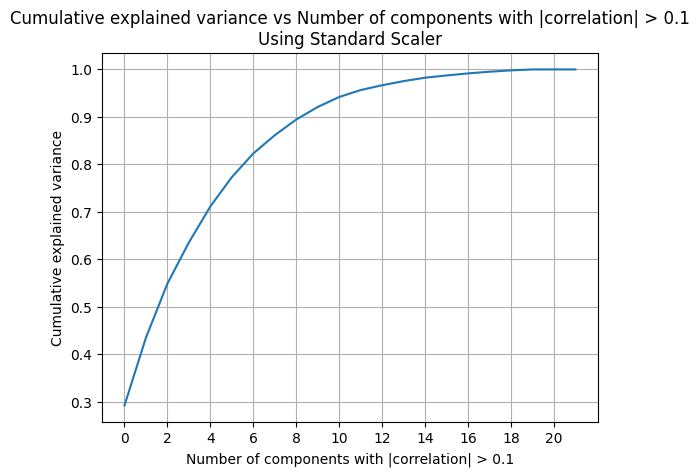

In [402]:
X_gt1 = df[cols_corr_gt1]
X_gt1 = X_gt1.drop(columns=["class"])

scaler_standard_gt1 = StandardScaler()
X_gt1_scaled = scaler_standard_gt1.fit_transform(X_gt1)

pca_corr_gt1_standard = PCA(n_components=len(cols_corr_gt1) - 1)
X_gt1_pca = pca_corr_gt1_standard.fit_transform(X_gt1_scaled)

pca_cumsum = pca_corr_gt1_standard.explained_variance_ratio_.cumsum()
plt.plot(pca_cumsum)
plt.xlabel("Number of components with |correlation| > 0.1")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs Number of components with |correlation| > 0.1\nUsing Standard Scaler")
plt.grid()
plt.xticks(range(0, len(cols_corr_gt1) - 1, 2))
plt.show()

In [403]:
print(f"at n={np.where(pca_cumsum > 0.95)[0][0]}, we have 95% of the variance explained")

# # %%
# scaler_minmax = MinMaxScaler()
# X_scaled = scaler_minmax.fit_transform(X)
#
# pca_minmax= PCA(n_components=len(df.columns) - 1)
# X_pca = pca_minmax.fit_transform(X_scaled)
#
# pca_cumsum = pca_minmax.explained_variance_ratio_.cumsum()
# plt.plot(pca_cumsum)
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative explained variance")
# plt.title("Cumulative explained variance vs Number of components\nUsing MinMax Scaler")
# plt.grid()
# plt.xticks(range(0, len(df.columns) - 1, 2))
# plt.show()
#
# # %%
# print(f"at n={np.where(pca_cumsum > 0.95)[0][0]}, we have 95% of the variance explained")
#
# # %%
# scaler_minmax_gt1 = MinMaxScaler()
# X_gt1_scaled = scaler_minmax_gt1.fit_transform(X_gt1)
#
# pca_corr_gt1_minmax = PCA(n_components=len(cols_corr_gt1) - 1)
# X_gt1_pca = pca_corr_gt1_minmax.fit_transform(X_gt1_scaled)
#
# pca_cumsum = pca_corr_gt1_minmax.explained_variance_ratio_.cumsum()
# plt.plot(pca_cumsum)
# plt.xlabel("Number of components with |correlation| > 0.1")
# plt.ylabel("Cumulative explained variance")
# plt.title("Cumulative explained variance vs Number of components with |correlation| > 0.1\nUsing MinMax Scaler")
# plt.grid()
# plt.xticks(range(0, len(cols_corr_gt1) - 1, 2))
# plt.show()
#
# # %%
# print(f"at n={np.where(pca_cumsum > 0.95)[0][0]}, we have 95% of the variance explained")

at n=11, we have 95% of the variance explained


# Modelling

In [404]:
_, _, __X__, _, _, __y__ = test_train_val_split(df)
df_known_attacks = pd.DataFrame(__X__)
df_known_attacks["class"] = __y__
df_known_attacks.reset_index(drop=True, inplace=True)

In [405]:
df_similar_attacks = pd.read_csv(similar_attacks_path, low_memory=False)
df_similar_attacks = df_similar_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_similar_attacks["class"] = df_similar_attacks["class"].replace({"normal": 0, "attack": 1})

df_new_attacks = pd.read_csv(new_attacks_path, low_memory=False)
df_new_attacks = df_new_attacks.drop(columns=["ip_RF", "ip_MF", "ip_offset"])
df_new_attacks["class"] = df_new_attacks["class"].replace({"normal": 0, "attack": 1})

In [406]:
if TESTING:
    df_similar_attacks = df_similar_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_similar_attacks.reset_index(drop=True, inplace=True)
    df_new_attacks = df_new_attacks.sample(frac=TESTING_SIZE, random_state=random_state)
    df_new_attacks.reset_index(drop=True, inplace=True)

In [407]:
def pipeline_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs:
        raise ValueError("df and scaler must be passed as keyword arguments for pipeline_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=df.columns[:-1])
    df_["class"] = df["class"]
    return df_

In [408]:
def pipeline_corr_gt1_scaled(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs:
        raise ValueError("df, scaler, and cols must be passed as keyword arguments for pipeline_corr_gt1_scaled")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]

    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pd.DataFrame(df_, columns=cols[:-1])
    df_["class"] = df["class"]
    return df_

In [409]:
def pipeline_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, and pca must be passed as keyword arguments for pipeline_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    pca = kwargs["pca"]
    pca_cols = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]

    df_ = df.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :pca_cols]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

In [410]:
def pipeline_corr_gt1_pca(**kwargs):
    if "df" not in kwargs or "scaler" not in kwargs or "cols" not in kwargs or "pca" not in kwargs:
        raise ValueError("df, scaler, cols, and pca must be passed as keyword arguments for pipeline_corr_gt1_pca")
    df = kwargs["df"]
    scaler = kwargs["scaler"]
    cols = kwargs["cols"]
    pca = kwargs["pca"]
    pca_cols = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]


    df_ = df[cols]
    df_ = df_.drop(columns=["class"])
    df_ = scaler.transform(df_)
    df_ = pca.transform(df_)
    df_ = df_[:, :pca_cols]
    df_ = pd.DataFrame(df_)
    df_["class"] = df["class"]
    return df_

## SVM

In [411]:
svm_params = {
    "C": [0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["poly", "rbf", "sigmoid", "linear"],
    "gamma": ["scale", "auto"],
}

In [412]:
verbose = 3
cv = 3
n_jobs = None

### All features scaled

In [413]:
df_scaled = pipeline_scaled(df=df, scaler=scaler_standard)
df_scaled.head()

,ip_type,ip_len,ip_id,ip_DF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,-0.13395,-0.072762,-1.610013,1.284948,1.935312,0.703691,2.198902,-0.336966,2.733911,1.974127,-0.118767,-0.13395,-0.141004,-1.108848,-0.628011,-1.015813,-0.730267,1.696638,1.694309,1.730547,1.766973,1.485600,1.782002,-0.041901,1.424987,0.337886,0.708187,1.360744,0.224995,2.556263,1.835189,2.536676,1.274109,-0.047407,-0.034428,-0.119399,-0.109876,-0.073112,0.018981,0.132414,0.166779,-0.283684,-0.047301,-0.12405,-0.472397,-0.068721,-0.310885,0.0
1,-0.13395,-0.150864,-1.610013,1.284948,1.935312,0.704549,1.799665,-0.336966,2.018858,2.225311,-0.118767,-0.13395,-0.141004,-1.108848,-0.628011,-1.015813,-0.730267,1.696638,1.694309,1.730547,1.766973,1.485600,1.782002,-0.120541,1.424987,0.115948,0.247593,-0.191978,-0.062718,0.984499,2.593928,0.021876,-0.256045,-0.046748,-0.034428,-0.119399,-0.109876,-0.072234,0.121865,0.227096,0.136742,-0.280109,-0.030150,-0.12405,-0.472397,-0.068721,-0.310885,0.0
2,-0.13395,-0.258254,1.483459,1.284948,-0.476999,0.966720,-0.416175,-0.348376,-0.394445,-0.430443,-0.118767,-0.13395,-0.141004,0.473858,-0.624065,-0.001700,-0.563040,-0.699775,-0.702793,-0.658254,-0.617950,0.096319,-0.602406,-0.287649,0.000837,-0.101859,-0.133854,-0.284571,-0.040755,-0.408105,3.442680,-0.369978,3.008033,-0.046748,-0.034428,-0.119399,-0.109876,-0.059949,0.018981,0.449109,0.359511,-0.280109,-0.030150,-0.12405,-0.472397,-0.068721,-0.310885,0.0
3,-0.13395,-0.316831,-1.441381,-0.778242,-0.476999,1.545125,-0.416175,-0.348376,-0.394445,-0.430443,-0.118767,-0.13395,-0.141004,0.678744,1.260737,0.468295,-0.730267,0.498431,-0.702793,-0.658254,-0.617950,-1.292962,-0.602406,-0.317139,-1.185955,-0.251785,-0.557073,-0.628829,-0.143541,-0.601653,-0.696668,-0.479345,-0.603160,-0.048066,-0.034428,-0.119399,-0.109876,-0.069602,-0.083903,-0.389969,-0.604151,-0.287259,-0.064452,-0.12405,-0.456760,-0.068721,-0.310885,1.0
4,-0.13395,2.182435,0.045883,-0.778242,-0.476999,-0.182636,-0.416175,-0.348376,-0.394445,-0.430443,-0.118767,-0.13395,-0.141004,-1.105575,1.678666,1.938612,1.015308,-0.699775,-0.702793,-0.658254,-0.617950,0.096319,-0.602406,2.169830,0.000837,-0.087692,-0.018431,-0.018662,0.061592,-0.082102,0.921169,-0.292575,1.696493,-0.042133,-0.034428,-0.119399,-0.109876,-0.072234,0.121865,0.524201,0.622328,-0.276534,-0.012999,-0.12405,-0.472397,-0.068721,-0.310885,0.0


In [414]:
(
    X_scaled_train,
    X_scaled_val,
    X_scaled_test,
    y_scaled_train,
    y_scaled_val,
    y_scaled_test,
) = test_train_val_split(df_scaled)

In [415]:
svm_scaled_baseline = SVC(random_state=random_state)
svm_scaled_baseline.fit(X_scaled_train, y_scaled_train)

SVC(random_state=245)

In [416]:
print(classification_report(y_scaled_val, svm_scaled_baseline.predict(X_scaled_val)))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        72
         1.0       1.00      0.95      0.97        56

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.98       128
weighted avg       0.98      0.98      0.98       128



In [417]:
svm_scaled_grid = GridSearchCV(SVC(random_state=random_state), svm_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
svm_scaled_grid.fit(X_scaled_val, y_scaled_val)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 2/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 3/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.571 total time=   0.0s
[CV 1/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 2/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 3/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=linear;, score=0.953 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=linear;, score=0.977 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=lin

[CV 2/3] END .C=1000, gamma=auto, kernel=linear;, score=0.977 total time=   0.0s
[CV 3/3] END .C=1000, gamma=auto, kernel=linear;, score=0.976 total time=   0.0s


GridSearchCV(cv=3, estimator=SVC(random_state=245),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             verbose=3)

In [418]:
print(svm_scaled_grid.best_params_)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [419]:
svm_scaled = SVC(**svm_scaled_grid.best_params_, random_state=random_state)
svm_scaled.fit(X_scaled_train, y_scaled_train)

SVC(C=0.1, kernel='linear', random_state=245)

In [420]:
print(classification_report(y_scaled_test, svm_scaled.predict(X_scaled_test)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        84
         1.0       1.00      0.98      0.99        44

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128



In [421]:
benchmarkAndUpdateResult(
        df_known_attacks,
        svm_scaled,
        f"SVM {svm_scaled_grid.best_params_}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99        84
         1.0       1.00      0.98      0.99        44

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128


Model: SVM {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Data size: 128
Accuracy: 0.9921875
Precision: 1.0
Recall: 0.9772727272727273
F1: 0.9885057471264368
Time per data per iter: 15963.3078125


In [422]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_scaled,
        f"SVM {svm_scaled_grid.best_params_}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       173
           1       0.98      0.98      0.98        91

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264


Model: SVM {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Data size: 264
Accuracy: 0.9848484848484849
Precision: 0.978021978021978
Recall: 0.978021978021978
F1: 0.978021978021978
Time per data per iter: 8919.113257575757


In [423]:
benchmarkAndUpdateResult(
        df_new_attacks,
        svm_scaled,
        f"SVM {svm_scaled_grid.best_params_}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       577
           1       0.86      0.16      0.28       182

    accuracy                           0.79       759
   macro avg       0.82      0.58      0.58       759
weighted avg       0.81      0.79      0.73       759


Model: SVM {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Data size: 759
Accuracy: 0.7931488801054019
Precision: 0.8571428571428571
Recall: 0.16483516483516483
F1: 0.27649769585253453
Time per data per iter: 3941.7533596837943


### Features with |correlation| > 0.1 scaled

In [424]:
df_corr_gt1_scaled = pipeline_corr_gt1_scaled(df=df, scaler=scaler_standard_gt1, cols=cols_corr_gt1)
df_corr_gt1_scaled.head()

,ip_type,ip_len,ip_DF,udp_sport,udp_len,icmp_code,tcp_sport,tcp_dport,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_fack,fr_length,conn_status,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_ack_src_dst,num_syn_src_dst,num_rst_dst_src,first_serv_packet,class
0,-0.13395,-0.072762,1.284948,2.198902,2.733911,-0.13395,-1.108848,-0.628011,-0.730267,1.696638,1.694309,1.485600,-0.041901,1.424987,2.556263,1.835189,2.536676,1.274109,0.132414,-0.283684,-0.472397,-0.310885,0.0
1,-0.13395,-0.150864,1.284948,1.799665,2.018858,-0.13395,-1.108848,-0.628011,-0.730267,1.696638,1.694309,1.485600,-0.120541,1.424987,0.984499,2.593928,0.021876,-0.256045,0.227096,-0.280109,-0.472397,-0.310885,0.0
2,-0.13395,-0.258254,1.284948,-0.416175,-0.394445,-0.13395,0.473858,-0.624065,-0.563040,-0.699775,-0.702793,0.096319,-0.287649,0.000837,-0.408105,3.442680,-0.369978,3.008033,0.449109,-0.280109,-0.472397,-0.310885,0.0
3,-0.13395,-0.316831,-0.778242,-0.416175,-0.394445,-0.13395,0.678744,1.260737,-0.730267,0.498431,-0.702793,-1.292962,-0.317139,-1.185955,-0.601653,-0.696668,-0.479345,-0.603160,-0.389969,-0.287259,-0.456760,-0.310885,1.0
4,-0.13395,2.182435,-0.778242,-0.416175,-0.394445,-0.13395,-1.105575,1.678666,1.015308,-0.699775,-0.702793,0.096319,2.169830,0.000837,-0.082102,0.921169,-0.292575,1.696493,0.524201,-0.276534,-0.472397,-0.310885,0.0


In [425]:
(
    X_corr_gt1_scaled_train,
    X_corr_gt1_scaled_val,
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_train,
    y_corr_gt1_scaled_val,
    y_corr_gt1_scaled_test,
) = test_train_val_split(df_corr_gt1_scaled)

In [426]:
svm_corr_gt1_scaled_baseline = SVC(random_state=random_state)
svm_corr_gt1_scaled_baseline.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

SVC(random_state=245)

In [427]:
print(classification_report(y_corr_gt1_scaled_val, svm_corr_gt1_scaled_baseline.predict(X_corr_gt1_scaled_val)))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        72
         1.0       0.96      0.98      0.97        56

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



In [428]:
svm_corr_gt1_scaled_grid = GridSearchCV(SVC(random_state=random_state), svm_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
svm_corr_gt1_scaled_grid.fit(X_corr_gt1_scaled_val, y_corr_gt1_scaled_val)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 2/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 3/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.571 total time=   0.0s
[CV 1/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 2/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 3/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=linear;, score=0.977 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=lin

[CV 2/3] END .....C=100, gamma=auto, kernel=rbf;, score=0.977 total time=   0.0s
[CV 3/3] END .....C=100, gamma=auto, kernel=rbf;, score=0.952 total time=   0.0s
[CV 1/3] END .C=100, gamma=auto, kernel=sigmoid;, score=0.907 total time=   0.0s
[CV 2/3] END .C=100, gamma=auto, kernel=sigmoid;, score=0.907 total time=   0.0s
[CV 3/3] END .C=100, gamma=auto, kernel=sigmoid;, score=0.905 total time=   0.0s
[CV 1/3] END ..C=100, gamma=auto, kernel=linear;, score=0.977 total time=   0.0s
[CV 2/3] END ..C=100, gamma=auto, kernel=linear;, score=0.953 total time=   0.0s
[CV 3/3] END ..C=100, gamma=auto, kernel=linear;, score=0.976 total time=   0.0s
[CV 1/3] END ..C=1000, gamma=scale, kernel=poly;, score=1.000 total time=   0.0s
[CV 2/3] END ..C=1000, gamma=scale, kernel=poly;, score=0.977 total time=   0.0s
[CV 3/3] END ..C=1000, gamma=scale, kernel=poly;, score=0.952 total time=   0.0s
[CV 1/3] END ...C=1000, gamma=scale, kernel=rbf;, score=0.977 total time=   0.0s
[CV 2/3] END ...C=1000, gamm

GridSearchCV(cv=3, estimator=SVC(random_state=245),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             verbose=3)

In [429]:
print(svm_corr_gt1_scaled_grid.best_params_)

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [430]:
svm_corr_gt1_scaled = SVC(**svm_corr_gt1_scaled_grid.best_params_, random_state=random_state)
svm_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

SVC(C=1, random_state=245)

In [431]:
print(classification_report(y_corr_gt1_scaled_test, svm_corr_gt1_scaled.predict(X_corr_gt1_scaled_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.98      0.95      0.97        44

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.97       128
weighted avg       0.98      0.98      0.98       128



In [432]:
benchmarkAndUpdateResult(
        df_known_attacks,
        svm_corr_gt1_scaled,
        f"SVM {svm_corr_gt1_scaled_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.98      0.95      0.97        44

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.97       128
weighted avg       0.98      0.98      0.98       128


Model: SVM {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 128
Accuracy: 0.9765625
Precision: 0.9767441860465116
Recall: 0.9545454545454546
F1: 0.9655172413793104
Time per data per iter: 18925.71953125


In [433]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_corr_gt1_scaled,
        f"SVM {svm_corr_gt1_scaled_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       173
           1       0.98      0.98      0.98        91

    accuracy                           0.98       264
   macro avg       0.98      0.98      0.98       264
weighted avg       0.98      0.98      0.98       264


Model: SVM {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 264
Accuracy: 0.9848484848484849
Precision: 0.978021978021978
Recall: 0.978021978021978
F1: 0.978021978021978
Time per data per iter: 11934.828787878787


In [434]:
benchmarkAndUpdateResult(
        df_new_attacks,
        svm_corr_gt1_scaled,
        f"SVM {svm_corr_gt1_scaled_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.77      0.99      0.86       577
           1       0.59      0.05      0.10       182

    accuracy                           0.76       759
   macro avg       0.68      0.52      0.48       759
weighted avg       0.73      0.76      0.68       759


Model: SVM {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Data size: 759
Accuracy: 0.764163372859025
Precision: 0.5882352941176471
Recall: 0.054945054945054944
F1: 0.10050251256281408
Time per data per iter: 6601.753359683795


### All features with 95% PCA

In [435]:
df_pca = pipeline_pca(df=df, scaler=scaler_standard, pca=pca_standard)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,class
0,7.373127,-2.210087,0.586955,1.145735,-1.154866,0.326854,1.173137,-0.313809,-0.066398,-0.189999,0.022345,-0.211091,0.565912,-0.292576,-0.157804,-0.163790,0.039133,-0.255842,0.557732,-0.116333,-1.392975,0.271878,0.893076,0.287924,0.083875,0.164183,0.0
1,5.952511,-0.920884,0.147301,0.056317,-1.716004,-0.023406,0.716288,-1.555294,-0.252579,-0.269692,0.023923,-0.379056,0.322398,-0.050366,-0.151775,-0.300107,-0.138358,-0.342097,0.394807,0.876301,-0.707046,-0.442790,0.542163,-0.944891,0.680096,-0.060658,0.0
2,-1.044127,-1.733833,2.245160,1.201700,-1.861521,-1.037362,-0.824242,0.818934,-0.251615,-0.378770,-0.138856,-0.591518,-0.144240,-0.537598,-0.099410,-0.485684,-0.727223,0.175045,0.475972,-0.421877,1.151200,-1.046946,0.340647,-0.700534,1.560320,0.755397,0.0
3,-2.070706,0.547305,-0.895051,-0.937838,-0.056595,-0.665321,2.320882,-0.067520,0.738407,0.295100,0.286806,0.068881,-0.084268,0.238801,-0.196036,0.024299,-0.197893,-0.100314,-0.238996,-0.903543,0.029477,-1.174912,0.143246,0.032535,-0.020935,-0.206009,1.0
4,-1.672413,-1.412844,3.611548,-1.153914,1.170361,1.498183,0.148634,-0.359101,-0.084893,0.052405,-0.570755,-0.221776,-0.038990,-0.043017,0.354976,-0.110676,-0.131108,-0.000562,0.073384,-0.249740,0.400509,-0.960367,0.824982,-0.502292,-0.687671,0.111002,0.0


In [436]:
(
    X_pca_train,
    X_pca_val,
    X_pca_test,
    y_pca_train,
    y_pca_val,
    y_pca_test,
) = test_train_val_split(df_pca)

In [437]:
svm_pca_baseline = SVC(random_state=random_state)
svm_pca_baseline.fit(X_pca_train, y_pca_train)

SVC(random_state=245)

In [438]:
print(classification_report(y_pca_val, svm_pca_baseline.predict(X_pca_val)))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        72
         1.0       0.98      0.95      0.96        56

    accuracy                           0.97       128
   macro avg       0.97      0.97      0.97       128
weighted avg       0.97      0.97      0.97       128



In [439]:
svm_pca_grid = GridSearchCV(SVC(random_state=random_state), svm_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
svm_pca_grid.fit(X_pca_val, y_pca_val)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 2/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 3/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.571 total time=   0.0s
[CV 1/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 2/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 3/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=linear;, score=0.977 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=linear;, score=1.000 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=lin

[CV 1/3] END ..C=1000, gamma=scale, kernel=poly;, score=0.977 total time=   0.0s
[CV 2/3] END ..C=1000, gamma=scale, kernel=poly;, score=0.907 total time=   0.0s
[CV 3/3] END ..C=1000, gamma=scale, kernel=poly;, score=0.929 total time=   0.0s
[CV 1/3] END ...C=1000, gamma=scale, kernel=rbf;, score=0.953 total time=   0.0s
[CV 2/3] END ...C=1000, gamma=scale, kernel=rbf;, score=0.930 total time=   0.0s
[CV 3/3] END ...C=1000, gamma=scale, kernel=rbf;, score=0.952 total time=   0.0s
[CV 1/3] END C=1000, gamma=scale, kernel=sigmoid;, score=0.907 total time=   0.0s
[CV 2/3] END C=1000, gamma=scale, kernel=sigmoid;, score=0.907 total time=   0.0s
[CV 3/3] END C=1000, gamma=scale, kernel=sigmoid;, score=0.976 total time=   0.0s
[CV 1/3] END C=1000, gamma=scale, kernel=linear;, score=0.953 total time=   0.0s
[CV 2/3] END C=1000, gamma=scale, kernel=linear;, score=0.953 total time=   0.0s
[CV 3/3] END C=1000, gamma=scale, kernel=linear;, score=0.976 total time=   0.0s
[CV 1/3] END ...C=1000, g

GridSearchCV(cv=3, estimator=SVC(random_state=245),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             verbose=3)

In [440]:
print(svm_pca_grid.best_params_)

{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}


In [441]:
svm_pca = SVC(**svm_pca_grid.best_params_, random_state=random_state)
svm_pca.fit(X_pca_train, y_pca_train)

SVC(C=0.01, kernel='linear', random_state=245)

In [442]:
print(classification_report(y_pca_test, svm_pca.predict(X_pca_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.98      0.95      0.97        44

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.97       128
weighted avg       0.98      0.98      0.98       128



In [443]:
benchmarkAndUpdateResult(
        df_known_attacks,
        svm_pca,
        f"SVM {svm_pca_grid.best_params_}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.98      0.95      0.97        44

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.97       128
weighted avg       0.98      0.98      0.98       128


Model: SVM {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Data size: 128
Accuracy: 0.9765625
Precision: 0.9767441860465116
Recall: 0.9545454545454546
F1: 0.9655172413793104
Time per data per iter: 37869.2078125


In [444]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_pca,
        f"SVM {svm_pca_grid.best_params_}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       173
           1       0.94      0.97      0.95        91

    accuracy                           0.97       264
   macro avg       0.96      0.97      0.96       264
weighted avg       0.97      0.97      0.97       264


Model: SVM {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Data size: 264
Accuracy: 0.9659090909090909
Precision: 0.9361702127659575
Recall: 0.967032967032967
F1: 0.9513513513513513
Time per data per iter: 37436.584848484854


In [445]:
benchmarkAndUpdateResult(
        df_new_attacks,
        svm_pca,
        f"SVM {svm_pca_grid.best_params_}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       577
           1       0.69      0.19      0.29       182

    accuracy                           0.79       759
   macro avg       0.74      0.58      0.58       759
weighted avg       0.77      0.79      0.73       759


Model: SVM {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Data size: 759
Accuracy: 0.7852437417654808
Precision: 0.6938775510204082
Recall: 0.18681318681318682
F1: 0.2943722943722944
Time per data per iter: 17024.11515151515


### Features with |correlation| > 0.1 with 95% PCA

In [446]:
df_corr_gt1_pca = pipeline_corr_gt1_pca(df=df, scaler=scaler_standard_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1_standard)
df_corr_gt1_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,class
0,6.267195,0.499474,-1.776037,-0.126681,0.281879,-0.251511,0.024146,-0.158035,-0.033299,-0.200340,-0.252115,0.0
1,4.502553,0.061352,-0.763381,0.227512,-0.149152,0.733408,1.021965,0.303100,-0.012360,0.921601,-0.384792,0.0
2,0.375079,2.449879,-1.802136,2.243522,-0.881194,-0.224126,-0.023823,-1.359535,-0.463393,2.781288,-0.453717,0.0
3,-1.824903,-0.713547,0.680425,-0.918766,-0.714741,0.010917,-1.055405,-0.697479,0.632134,0.304332,0.409989,1.0
4,-0.297743,3.849588,1.563681,-0.710010,1.284272,-0.362670,0.087616,-0.283982,0.263352,0.784822,-0.297685,0.0


In [447]:
(
    X_corr_gt1_pca_train,
    X_corr_gt1_pca_val,
    X_corr_gt1_pca_test,
    y_corr_gt1_pca_train,
    y_corr_gt1_pca_val,
    y_corr_gt1_pca_test,
) = test_train_val_split(df_corr_gt1_pca)

In [448]:
svm_corr_gt1_pca_baseline = SVC(random_state=random_state)
svm_corr_gt1_pca_baseline.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

SVC(random_state=245)

In [449]:
print(classification_report(y_corr_gt1_pca_val, svm_corr_gt1_pca_baseline.predict(X_corr_gt1_pca_val)))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99        72
         1.0       0.98      1.00      0.99        56

    accuracy                           0.99       128
   macro avg       0.99      0.99      0.99       128
weighted avg       0.99      0.99      0.99       128



In [450]:
svm_corr_gt1_pca_grid = GridSearchCV(SVC(random_state=random_state), svm_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
svm_corr_gt1_pca_grid.fit(X_corr_gt1_pca_val, y_corr_gt1_pca_val)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 2/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.558 total time=   0.0s
[CV 3/3] END ..C=0.01, gamma=scale, kernel=poly;, score=0.571 total time=   0.0s
[CV 1/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 2/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.558 total time=   0.0s
[CV 3/3] END ...C=0.01, gamma=scale, kernel=rbf;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.558 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=sigmoid;, score=0.571 total time=   0.0s
[CV 1/3] END C=0.01, gamma=scale, kernel=linear;, score=0.977 total time=   0.0s
[CV 2/3] END C=0.01, gamma=scale, kernel=linear;, score=0.953 total time=   0.0s
[CV 3/3] END C=0.01, gamma=scale, kernel=lin

[CV 2/3] END ...C=1000, gamma=auto, kernel=poly;, score=0.977 total time=   0.0s
[CV 3/3] END ...C=1000, gamma=auto, kernel=poly;, score=0.952 total time=   0.0s
[CV 1/3] END ....C=1000, gamma=auto, kernel=rbf;, score=1.000 total time=   0.0s
[CV 2/3] END ....C=1000, gamma=auto, kernel=rbf;, score=1.000 total time=   0.0s
[CV 3/3] END ....C=1000, gamma=auto, kernel=rbf;, score=0.952 total time=   0.0s
[CV 1/3] END C=1000, gamma=auto, kernel=sigmoid;, score=0.651 total time=   0.0s
[CV 2/3] END C=1000, gamma=auto, kernel=sigmoid;, score=0.860 total time=   0.0s
[CV 3/3] END C=1000, gamma=auto, kernel=sigmoid;, score=0.857 total time=   0.0s
[CV 1/3] END .C=1000, gamma=auto, kernel=linear;, score=0.977 total time=   0.0s
[CV 2/3] END .C=1000, gamma=auto, kernel=linear;, score=0.953 total time=   0.0s
[CV 3/3] END .C=1000, gamma=auto, kernel=linear;, score=0.952 total time=   0.0s


GridSearchCV(cv=3, estimator=SVC(random_state=245),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid', 'linear']},
             verbose=3)

In [451]:
print(svm_corr_gt1_pca_grid.best_params_)

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [452]:
svm_corr_gt1_pca = SVC(**svm_corr_gt1_pca_grid.best_params_, random_state=random_state)
svm_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

SVC(C=1, gamma='auto', random_state=245)

In [453]:
print(classification_report(y_corr_gt1_pca_test, svm_corr_gt1_pca.predict(X_corr_gt1_pca_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.98      0.95      0.97        44

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.97       128
weighted avg       0.98      0.98      0.98       128



In [454]:
benchmarkAndUpdateResult(
        df_known_attacks,
        svm_corr_gt1_pca,
        f"SVM {svm_corr_gt1_pca_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98        84
         1.0       0.98      0.95      0.97        44

    accuracy                           0.98       128
   macro avg       0.98      0.97      0.97       128
weighted avg       0.98      0.98      0.98       128


Model: SVM {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 128
Accuracy: 0.9765625
Precision: 0.9767441860465116
Recall: 0.9545454545454546
F1: 0.9655172413793104
Time per data per iter: 22438.6109375


In [455]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        svm_corr_gt1_pca,
        f"SVM {svm_corr_gt1_pca_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       173
           1       0.97      0.96      0.96        91

    accuracy                           0.97       264
   macro avg       0.97      0.97      0.97       264
weighted avg       0.97      0.97      0.97       264


Model: SVM {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 264
Accuracy: 0.9734848484848485
Precision: 0.9666666666666667
Recall: 0.9560439560439561
F1: 0.9613259668508287
Time per data per iter: 12982.80946969697


In [456]:
benchmarkAndUpdateResult(
        df_new_attacks,
        svm_corr_gt1_pca,
        f"SVM {svm_corr_gt1_pca_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

# # %% [markdown]
# # ## Complement Naive Bayes
#
# # %%
# cnb_params = {
#     "alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#     "force_alpha": [True, False],
#     "fit_prior": [True, False],
#     "norm": [True, False],
# }
#
# # %% [markdown]
# # ### All features scaled
#
# # %%
# df_scaled = pipeline_scaled(df=df, scaler=scaler_minmax)
# df_scaled.head()
#
# # %%
# (
#     X_scaled_train,
#     X_scaled_val,
#     X_scaled_test,
#     y_scaled_train,
#     y_scaled_val,
#     y_scaled_test,
# ) = test_train_val_split(df_scaled)
#
# # %%
# cnb_scaled_baseline = ComplementNB()
# cnb_scaled_baseline.fit(X_scaled_train, y_scaled_train)
#
# # %%
# print(classification_report(y_scaled_val, cnb_scaled_baseline.predict(X_scaled_val)))
#
# # %%
# cnb_scaled_grid = GridSearchCV(ComplementNB(), cnb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
# cnb_scaled_grid.fit(X_scaled_val, y_scaled_val)
#
# # %%
# print(cnb_scaled_grid.best_params_)
#
# # %%
# cnb_scaled = ComplementNB(**cnb_scaled_grid.best_params_)
# cnb_scaled.fit(X_scaled_train, y_scaled_train)
#
# # %%
# print(classification_report(y_scaled_test, cnb_scaled.predict(X_scaled_test)))
#
# # %%
# benchmarkAndUpdateResult(
#         df_known_attacks,
#         cnb_scaled,
#         f"ComplementNB {cnb_scaled_grid.best_params_}",
#         "Known attacks",
#         "All features scaled",
#         pipeline_scaled,
#         scaler=scaler_minmax
#         )
#
# # %%
# benchmarkAndUpdateResult(
#         df_similar_attacks,
#         cnb_scaled,
#         f"ComplementNB {cnb_scaled_grid.best_params_}",
#         "Similar attacks",
#         "All features scaled",
#         pipeline_scaled,
#         scaler=scaler_minmax
#         )
#
# # %%
# benchmarkAndUpdateResult(
#         df_new_attacks,
#         cnb_scaled,
#         f"ComplementNB {cnb_scaled_grid.best_params_}",
#         "New attacks",
#         "All features scaled",
#         pipeline_scaled,
#         scaler=scaler_minmax
#         )
#
# # %% [markdown]
# # ### Features with |correlation| > 0.1 scaled
#
# # %%
# df_corr_gt1_scaled = pipeline_corr_gt1_scaled(df=df, scaler=scaler_minmax_gt1, cols=cols_corr_gt1)
# df_corr_gt1_scaled.head()
#
# # %%
# (
#     X_corr_gt1_scaled_train,
#     X_corr_gt1_scaled_val,
#     X_corr_gt1_scaled_test,
#     y_corr_gt1_scaled_train,
#     y_corr_gt1_scaled_val,
#     y_corr_gt1_scaled_test,
# ) = test_train_val_split(df_corr_gt1_scaled)
#
# # %%
# cnb_corr_gt1_scaled_baseline = ComplementNB()
# cnb_corr_gt1_scaled_baseline.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)
#
# # %%
# print(classification_report(y_corr_gt1_scaled_val, cnb_corr_gt1_scaled_baseline.predict(X_corr_gt1_scaled_val)))
#
# # %%
# cnb_corr_gt1_scaled_grid = GridSearchCV(ComplementNB(), cnb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
# cnb_corr_gt1_scaled_grid.fit(X_corr_gt1_scaled_val, y_corr_gt1_scaled_val)
#
# # %%
# print(cnb_corr_gt1_scaled_grid.best_params_)
#
# # %%
# cnb_corr_gt1_scaled = ComplementNB(**cnb_corr_gt1_scaled_grid.best_params_)
# cnb_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)
#
# # %%
# print(classification_report(y_corr_gt1_scaled_test, cnb_corr_gt1_scaled.predict(X_corr_gt1_scaled_test)))
#
# # %%
# benchmarkAndUpdateResult(
#         df_known_attacks,
#         cnb_corr_gt1_scaled,
#         f"ComplementNB {cnb_corr_gt1_scaled_grid.best_params_}",
#         "Known attacks",
#         "|correlation| > 0.1 features scaled",
#         pipeline_corr_gt1_scaled,
#         scaler=scaler_minmax_gt1,
#         cols=cols_corr_gt1
#         )
#
# # %%
# benchmarkAndUpdateResult(
#         df_similar_attacks,
#         cnb_corr_gt1_scaled,
#         f"ComplementNB {cnb_corr_gt1_scaled_grid.best_params_}",
#         "Similar attacks",
#         "|correlation| > 0.1 features scaled",
#         pipeline_corr_gt1_scaled,
#         scaler=scaler_minmax_gt1,
#         cols=cols_corr_gt1
#         )
#
# # %%
# benchmarkAndUpdateResult(
#         df_new_attacks,
#         cnb_corr_gt1_scaled,
#         f"ComplementNB {cnb_corr_gt1_scaled_grid.best_params_}",
#         "New attacks",
#         "|correlation| > 0.1 features scaled",
#         pipeline_corr_gt1_scaled,
#         scaler=scaler_minmax_gt1,
#         cols=cols_corr_gt1
#         )
#

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       577
           1       0.59      0.07      0.13       182

    accuracy                           0.77       759
   macro avg       0.68      0.53      0.50       759
weighted avg       0.73      0.77      0.69       759


Model: SVM {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Data size: 759
Accuracy: 0.7654808959156785
Precision: 0.5909090909090909
Recall: 0.07142857142857142
F1: 0.12745098039215685
Time per data per iter: 16380.688274044796


## Gaussian Naive Bayes

In [457]:
gnb_params = {'var_smoothing': np.logspace(0,-9, num=100)}

### All features scaled

In [458]:
df_scaled = pipeline_scaled(df=df, scaler=scaler_standard)
df_scaled.head()

,ip_type,ip_len,ip_id,ip_DF,ip_proto,ip_checksum,udp_sport,udp_dport,udp_len,udp_chk,icmp_type,icmp_code,icmp_chk,tcp_sport,tcp_dport,tcp_seq,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_frst,tcp_fpush,tcp_fack,tcp_furg,fr_length,conn_status,count_fr_src_dst,count_fr_dst_src,count_serv_src_dst,count_serv_dst_src,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_pushed_src_dst,num_pushed_dst_src,num_syn_fin_src_dst,num_syn_fin_dst_src,num_fin_src_dst,num_fin_dst_src,num_ack_src_dst,num_ack_dst_src,num_syn_src_dst,num_syn_dst_src,num_rst_src_dst,num_rst_dst_src,first_packet,first_serv_packet,class
0,-0.13395,-0.072762,-1.610013,1.284948,1.935312,0.703691,2.198902,-0.336966,2.733911,1.974127,-0.118767,-0.13395,-0.141004,-1.108848,-0.628011,-1.015813,-0.730267,1.696638,1.694309,1.730547,1.766973,1.485600,1.782002,-0.041901,1.424987,0.337886,0.708187,1.360744,0.224995,2.556263,1.835189,2.536676,1.274109,-0.047407,-0.034428,-0.119399,-0.109876,-0.073112,0.018981,0.132414,0.166779,-0.283684,-0.047301,-0.12405,-0.472397,-0.068721,-0.310885,0.0
1,-0.13395,-0.150864,-1.610013,1.284948,1.935312,0.704549,1.799665,-0.336966,2.018858,2.225311,-0.118767,-0.13395,-0.141004,-1.108848,-0.628011,-1.015813,-0.730267,1.696638,1.694309,1.730547,1.766973,1.485600,1.782002,-0.120541,1.424987,0.115948,0.247593,-0.191978,-0.062718,0.984499,2.593928,0.021876,-0.256045,-0.046748,-0.034428,-0.119399,-0.109876,-0.072234,0.121865,0.227096,0.136742,-0.280109,-0.030150,-0.12405,-0.472397,-0.068721,-0.310885,0.0
2,-0.13395,-0.258254,1.483459,1.284948,-0.476999,0.966720,-0.416175,-0.348376,-0.394445,-0.430443,-0.118767,-0.13395,-0.141004,0.473858,-0.624065,-0.001700,-0.563040,-0.699775,-0.702793,-0.658254,-0.617950,0.096319,-0.602406,-0.287649,0.000837,-0.101859,-0.133854,-0.284571,-0.040755,-0.408105,3.442680,-0.369978,3.008033,-0.046748,-0.034428,-0.119399,-0.109876,-0.059949,0.018981,0.449109,0.359511,-0.280109,-0.030150,-0.12405,-0.472397,-0.068721,-0.310885,0.0
3,-0.13395,-0.316831,-1.441381,-0.778242,-0.476999,1.545125,-0.416175,-0.348376,-0.394445,-0.430443,-0.118767,-0.13395,-0.141004,0.678744,1.260737,0.468295,-0.730267,0.498431,-0.702793,-0.658254,-0.617950,-1.292962,-0.602406,-0.317139,-1.185955,-0.251785,-0.557073,-0.628829,-0.143541,-0.601653,-0.696668,-0.479345,-0.603160,-0.048066,-0.034428,-0.119399,-0.109876,-0.069602,-0.083903,-0.389969,-0.604151,-0.287259,-0.064452,-0.12405,-0.456760,-0.068721,-0.310885,1.0
4,-0.13395,2.182435,0.045883,-0.778242,-0.476999,-0.182636,-0.416175,-0.348376,-0.394445,-0.430443,-0.118767,-0.13395,-0.141004,-1.105575,1.678666,1.938612,1.015308,-0.699775,-0.702793,-0.658254,-0.617950,0.096319,-0.602406,2.169830,0.000837,-0.087692,-0.018431,-0.018662,0.061592,-0.082102,0.921169,-0.292575,1.696493,-0.042133,-0.034428,-0.119399,-0.109876,-0.072234,0.121865,0.524201,0.622328,-0.276534,-0.012999,-0.12405,-0.472397,-0.068721,-0.310885,0.0


In [459]:
(
    X_scaled_train,
    X_scaled_val,
    X_scaled_test,
    y_scaled_train,
    y_scaled_val,
    y_scaled_test,
) = test_train_val_split(df_scaled)

In [460]:
gnb_scaled_baseline = GaussianNB()
gnb_scaled_baseline.fit(X_scaled_train, y_scaled_train)

GaussianNB()

In [461]:
print(classification_report(y_scaled_val, gnb_scaled_baseline.predict(X_scaled_val)))

              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86        72
         1.0       0.76      0.98      0.86        56

    accuracy                           0.86       128
   macro avg       0.87      0.87      0.86       128
weighted avg       0.89      0.86      0.86       128



In [462]:
gnb_scaled_grid = GridSearchCV(GaussianNB(), gnb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
gnb_scaled_grid.fit(X_scaled_val, y_scaled_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.791 total time=   0.0s
[CV 2/3] END .................var_smoothing=1.0;, score=0.884 total time=   0.0s
[CV 3/3] END .................var_smoothing=1.0;, score=0.571 total time=   0.0s
[CV 1/3] END ..var_smoothing=0.8111308307896871;, score=0.884 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.8111308307896871;, score=0.814 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.8111308307896871;, score=0.595 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.657933224657568;, score=0.953 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.657933224657568;, score=0.767 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.657933224657568;, score=0.667 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.533669923120631;, score=0.953 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.533669923120631;, score=0.698 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.53366992312063

[CV 2/3] END var_smoothing=0.0004328761281083057;, score=0.791 total time=   0.0s
[CV 3/3] END var_smoothing=0.0004328761281083057;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0003511191734215131;, score=0.837 total time=   0.0s
[CV 2/3] END var_smoothing=0.0003511191734215131;, score=0.791 total time=   0.0s
[CV 3/3] END var_smoothing=0.0003511191734215131;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0002848035868435802;, score=0.837 total time=   0.0s
[CV 2/3] END var_smoothing=0.0002848035868435802;, score=0.814 total time=   0.0s
[CV 3/3] END var_smoothing=0.0002848035868435802;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0002310129700083158;, score=0.837 total time=   0.0s
[CV 2/3] END var_smoothing=0.0002310129700083158;, score=0.837 total time=   0.0s
[CV 3/3] END var_smoothing=0.0002310129700083158;, score=0.905 total time=   0.0s
[CV 1/3] END var_smoothing=0.0001873817422860383;, score=0.860 total time=   0.0s
[CV 2/3] END var

[CV 2/3] END var_smoothing=2.310129700083158e-07;, score=0.907 total time=   0.0s
[CV 3/3] END var_smoothing=2.310129700083158e-07;, score=0.786 total time=   0.0s
[CV 1/3] END var_smoothing=1.873817422860383e-07;, score=0.930 total time=   0.0s
[CV 2/3] END var_smoothing=1.873817422860383e-07;, score=0.907 total time=   0.0s
[CV 3/3] END var_smoothing=1.873817422860383e-07;, score=0.786 total time=   0.0s
[CV 1/3] END var_smoothing=1.519911082952933e-07;, score=0.930 total time=   0.0s
[CV 2/3] END var_smoothing=1.519911082952933e-07;, score=0.907 total time=   0.0s
[CV 3/3] END var_smoothing=1.519911082952933e-07;, score=0.786 total time=   0.0s
[CV 1/3] END var_smoothing=1.232846739442066e-07;, score=0.930 total time=   0.0s
[CV 2/3] END var_smoothing=1.232846739442066e-07;, score=0.907 total time=   0.0s
[CV 3/3] END var_smoothing=1.232846739442066e-07;, score=0.762 total time=   0.0s
[CV 1/3] END ...............var_smoothing=1e-07;, score=0.930 total time=   0.0s
[CV 2/3] END ....

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

In [463]:
print(gnb_scaled_grid.best_params_)

{'var_smoothing': 2.310129700083158e-05}


In [464]:
gnb_scaled = GaussianNB(**gnb_scaled_grid.best_params_)
gnb_scaled.fit(X_scaled_train, y_scaled_train)

GaussianNB(var_smoothing=2.310129700083158e-05)

In [465]:
print(classification_report(y_scaled_test, gnb_scaled.predict(X_scaled_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        84
         1.0       0.68      1.00      0.81        44

    accuracy                           0.84       128
   macro avg       0.84      0.88      0.83       128
weighted avg       0.89      0.84      0.84       128



In [466]:
benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_scaled,
        f"GaussianNB {gnb_scaled_grid.best_params_}",
        "Known attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86        84
         1.0       0.68      1.00      0.81        44

    accuracy                           0.84       128
   macro avg       0.84      0.88      0.83       128
weighted avg       0.89      0.84      0.84       128


Model: GaussianNB {'var_smoothing': 2.310129700083158e-05}
Data size: 128
Accuracy: 0.8359375
Precision: 0.676923076923077
Recall: 1.0
F1: 0.8073394495412844
Time per data per iter: 15719.8625


In [467]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_scaled,
        f"GaussianNB {gnb_scaled_grid.best_params_}",
        "Similar attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       173
           1       0.70      0.88      0.78        91

    accuracy                           0.83       264
   macro avg       0.81      0.84      0.82       264
weighted avg       0.85      0.83      0.83       264


Model: GaussianNB {'var_smoothing': 2.310129700083158e-05}
Data size: 264
Accuracy: 0.8295454545454546
Precision: 0.7017543859649122
Recall: 0.8791208791208791
F1: 0.7804878048780487
Time per data per iter: 8654.650757575757


In [468]:
benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_scaled,
        f"GaussianNB {gnb_scaled_grid.best_params_}",
        "New attacks",
        "All features scaled",
        pipeline_scaled,
        scaler=scaler_standard
        )

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       577
           1       0.07      0.02      0.03       182

    accuracy                           0.71       759
   macro avg       0.41      0.47      0.43       759
weighted avg       0.59      0.71      0.64       759


Model: GaussianNB {'var_smoothing': 2.310129700083158e-05}
Data size: 759
Accuracy: 0.7114624505928854
Precision: 0.06976744186046512
Recall: 0.016483516483516484
F1: 0.026666666666666665
Time per data per iter: 3287.4604743083


### Features with |correlation| > 0.1 scaled

In [469]:
df_corr_gt1_scaled = pipeline_corr_gt1_scaled(df=df, scaler=scaler_standard_gt1, cols=cols_corr_gt1)
df_corr_gt1_scaled.head()

,ip_type,ip_len,ip_DF,udp_sport,udp_len,icmp_code,tcp_sport,tcp_dport,tcp_ack,tcp_ffyn,tcp_fsyn,tcp_fack,fr_length,conn_status,num_bytes_src_dst,num_bytes_dst_src,num_bytes_serv_src_dst,num_bytes_serv_dst_src,num_ack_src_dst,num_syn_src_dst,num_rst_dst_src,first_serv_packet,class
0,-0.13395,-0.072762,1.284948,2.198902,2.733911,-0.13395,-1.108848,-0.628011,-0.730267,1.696638,1.694309,1.485600,-0.041901,1.424987,2.556263,1.835189,2.536676,1.274109,0.132414,-0.283684,-0.472397,-0.310885,0.0
1,-0.13395,-0.150864,1.284948,1.799665,2.018858,-0.13395,-1.108848,-0.628011,-0.730267,1.696638,1.694309,1.485600,-0.120541,1.424987,0.984499,2.593928,0.021876,-0.256045,0.227096,-0.280109,-0.472397,-0.310885,0.0
2,-0.13395,-0.258254,1.284948,-0.416175,-0.394445,-0.13395,0.473858,-0.624065,-0.563040,-0.699775,-0.702793,0.096319,-0.287649,0.000837,-0.408105,3.442680,-0.369978,3.008033,0.449109,-0.280109,-0.472397,-0.310885,0.0
3,-0.13395,-0.316831,-0.778242,-0.416175,-0.394445,-0.13395,0.678744,1.260737,-0.730267,0.498431,-0.702793,-1.292962,-0.317139,-1.185955,-0.601653,-0.696668,-0.479345,-0.603160,-0.389969,-0.287259,-0.456760,-0.310885,1.0
4,-0.13395,2.182435,-0.778242,-0.416175,-0.394445,-0.13395,-1.105575,1.678666,1.015308,-0.699775,-0.702793,0.096319,2.169830,0.000837,-0.082102,0.921169,-0.292575,1.696493,0.524201,-0.276534,-0.472397,-0.310885,0.0


In [470]:
(
    X_corr_gt1_scaled_train,
    X_corr_gt1_scaled_val,
    X_corr_gt1_scaled_test,
    y_corr_gt1_scaled_train,
    y_corr_gt1_scaled_val,
    y_corr_gt1_scaled_test,
) = test_train_val_split(df_corr_gt1_scaled)

In [471]:
gnb_corr_gt1_scaled_baseline = GaussianNB()
gnb_corr_gt1_scaled_baseline.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

GaussianNB()

In [472]:
print(classification_report(y_corr_gt1_scaled_val, gnb_corr_gt1_scaled_baseline.predict(X_corr_gt1_scaled_val)))

              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78        72
         1.0       0.68      1.00      0.81        56

    accuracy                           0.80       128
   macro avg       0.84      0.82      0.80       128
weighted avg       0.86      0.80      0.79       128



In [473]:
gnb_corr_gt1_scaled_grid = GridSearchCV(GaussianNB(), gnb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
gnb_corr_gt1_scaled_grid.fit(X_corr_gt1_scaled_val, y_corr_gt1_scaled_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.767 total time=   0.0s
[CV 2/3] END .................var_smoothing=1.0;, score=0.674 total time=   0.0s
[CV 3/3] END .................var_smoothing=1.0;, score=0.667 total time=   0.0s
[CV 1/3] END ..var_smoothing=0.8111308307896871;, score=0.767 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.8111308307896871;, score=0.674 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.8111308307896871;, score=0.667 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.657933224657568;, score=0.767 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.657933224657568;, score=0.674 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.657933224657568;, score=0.667 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.533669923120631;, score=0.791 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.533669923120631;, score=0.674 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.53366992312063

[CV 3/3] END var_smoothing=0.0006579332246575676;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0005336699231206307;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=0.0005336699231206307;, score=0.837 total time=   0.0s
[CV 3/3] END var_smoothing=0.0005336699231206307;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0004328761281083057;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=0.0004328761281083057;, score=0.837 total time=   0.0s
[CV 3/3] END var_smoothing=0.0004328761281083057;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0003511191734215131;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=0.0003511191734215131;, score=0.837 total time=   0.0s
[CV 3/3] END var_smoothing=0.0003511191734215131;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0002848035868435802;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=0.0002848035868435802;, score=0.837 total time=   0.0s
[CV 3/3] END var

[CV 1/3] END var_smoothing=5.336699231206313e-07;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=5.336699231206313e-07;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=5.336699231206313e-07;, score=0.857 total time=   0.0s
[CV 1/3] END var_smoothing=4.3287612810830526e-07;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=4.3287612810830526e-07;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=4.3287612810830526e-07;, score=0.857 total time=   0.0s
[CV 1/3] END var_smoothing=3.5111917342151277e-07;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=3.5111917342151277e-07;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=3.5111917342151277e-07;, score=0.857 total time=   0.0s
[CV 1/3] END var_smoothing=2.848035868435799e-07;, score=0.884 total time=   0.0s
[CV 2/3] END var_smoothing=2.848035868435799e-07;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=2.848035868435799e-07;, score=0.857 total time=   0.0s
[CV 1/3] E

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

In [474]:
print(gnb_corr_gt1_scaled_grid.best_params_)

{'var_smoothing': 2.848035868435799e-05}


In [475]:
gnb_corr_gt1_scaled = GaussianNB(**gnb_corr_gt1_scaled_grid.best_params_)
gnb_corr_gt1_scaled.fit(X_corr_gt1_scaled_train, y_corr_gt1_scaled_train)

GaussianNB(var_smoothing=2.848035868435799e-05)

In [476]:
print(classification_report(y_corr_gt1_scaled_test, gnb_corr_gt1_scaled.predict(X_corr_gt1_scaled_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85        84
         1.0       0.67      0.98      0.80        44

    accuracy                           0.83       128
   macro avg       0.83      0.86      0.82       128
weighted avg       0.88      0.83      0.83       128



In [477]:
benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_corr_gt1_scaled,
        f"GaussianNB {gnb_corr_gt1_scaled_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

         0.0       0.98      0.75      0.85        84
         1.0       0.67      0.98      0.80        44

    accuracy                           0.83       128
   macro avg       0.83      0.86      0.82       128
weighted avg       0.88      0.83      0.83       128


Model: GaussianNB {'var_smoothing': 2.848035868435799e-05}
Data size: 128
Accuracy: 0.828125
Precision: 0.671875
Recall: 0.9772727272727273
F1: 0.7962962962962963
Time per data per iter: 16162.5296875


In [478]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_corr_gt1_scaled,
        f"GaussianNB {gnb_corr_gt1_scaled_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       173
           1       0.65      1.00      0.78        91

    accuracy                           0.81       264
   macro avg       0.82      0.86      0.81       264
weighted avg       0.88      0.81      0.82       264


Model: GaussianNB {'var_smoothing': 2.848035868435799e-05}
Data size: 264
Accuracy: 0.8106060606060606
Precision: 0.6453900709219859
Recall: 1.0
F1: 0.7844827586206896
Time per data per iter: 8541.095075757576


In [479]:
benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_corr_gt1_scaled,
        f"GaussianNB {gnb_corr_gt1_scaled_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features scaled",
        pipeline_corr_gt1_scaled,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1
        )

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       577
           1       0.33      0.21      0.26       182

    accuracy                           0.71       759
   macro avg       0.56      0.54      0.54       759
weighted avg       0.67      0.71      0.68       759


Model: GaussianNB {'var_smoothing': 2.848035868435799e-05}
Data size: 759
Accuracy: 0.7101449275362319
Precision: 0.3333333333333333
Recall: 0.2087912087912088
F1: 0.2567567567567568
Time per data per iter: 2941.4752305665347


### All features with 95% PCA

In [480]:
df_pca = pipeline_pca(df=df, scaler=scaler_standard, pca=pca_standard)
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,class
0,7.373127,-2.210087,0.586955,1.145735,-1.154866,0.326854,1.173137,-0.313809,-0.066398,-0.189999,0.022345,-0.211091,0.565912,-0.292576,-0.157804,-0.163790,0.039133,-0.255842,0.557732,-0.116333,-1.392975,0.271878,0.893076,0.287924,0.083875,0.164183,0.0
1,5.952511,-0.920884,0.147301,0.056317,-1.716004,-0.023406,0.716288,-1.555294,-0.252579,-0.269692,0.023923,-0.379056,0.322398,-0.050366,-0.151775,-0.300107,-0.138358,-0.342097,0.394807,0.876301,-0.707046,-0.442790,0.542163,-0.944891,0.680096,-0.060658,0.0
2,-1.044127,-1.733833,2.245160,1.201700,-1.861521,-1.037362,-0.824242,0.818934,-0.251615,-0.378770,-0.138856,-0.591518,-0.144240,-0.537598,-0.099410,-0.485684,-0.727223,0.175045,0.475972,-0.421877,1.151200,-1.046946,0.340647,-0.700534,1.560320,0.755397,0.0
3,-2.070706,0.547305,-0.895051,-0.937838,-0.056595,-0.665321,2.320882,-0.067520,0.738407,0.295100,0.286806,0.068881,-0.084268,0.238801,-0.196036,0.024299,-0.197893,-0.100314,-0.238996,-0.903543,0.029477,-1.174912,0.143246,0.032535,-0.020935,-0.206009,1.0
4,-1.672413,-1.412844,3.611548,-1.153914,1.170361,1.498183,0.148634,-0.359101,-0.084893,0.052405,-0.570755,-0.221776,-0.038990,-0.043017,0.354976,-0.110676,-0.131108,-0.000562,0.073384,-0.249740,0.400509,-0.960367,0.824982,-0.502292,-0.687671,0.111002,0.0


In [481]:
(
    X_pca_train,
    X_pca_val,
    X_pca_test,
    y_pca_train,
    y_pca_val,
    y_pca_test,
) = test_train_val_split(df_pca)

In [482]:
gnb_pca_baseline = GaussianNB()
gnb_pca_baseline.fit(X_pca_train, y_pca_train)

GaussianNB()

In [483]:
print(classification_report(y_pca_val, gnb_pca_baseline.predict(X_pca_val)))

              precision    recall  f1-score   support

         0.0       0.89      0.57      0.69        72
         1.0       0.62      0.91      0.74        56

    accuracy                           0.72       128
   macro avg       0.76      0.74      0.72       128
weighted avg       0.77      0.72      0.71       128



In [484]:
gnb_pca_grid = GridSearchCV(GaussianNB(), gnb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
gnb_pca_grid.fit(X_pca_val, y_pca_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.605 total time=   0.0s
[CV 2/3] END .................var_smoothing=1.0;, score=0.698 total time=   0.0s
[CV 3/3] END .................var_smoothing=1.0;, score=0.571 total time=   0.0s
[CV 1/3] END ..var_smoothing=0.8111308307896871;, score=0.605 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.8111308307896871;, score=0.767 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.8111308307896871;, score=0.571 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.657933224657568;, score=0.605 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.657933224657568;, score=0.791 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.657933224657568;, score=0.571 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.533669923120631;, score=0.605 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.533669923120631;, score=0.814 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.53366992312063

[CV 2/3] END var_smoothing=0.0006579332246575676;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=0.0006579332246575676;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=0.0005336699231206307;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=0.0005336699231206307;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=0.0005336699231206307;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=0.0004328761281083057;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=0.0004328761281083057;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=0.0004328761281083057;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=0.0003511191734215131;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=0.0003511191734215131;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=0.0003511191734215131;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=0.0002848035868435802;, score=0.581 total time=   0.0s
[CV 2/3] END var

[CV 3/3] END var_smoothing=2.848035868435799e-07;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=2.310129700083158e-07;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=2.310129700083158e-07;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=2.310129700083158e-07;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=1.873817422860383e-07;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=1.873817422860383e-07;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=1.873817422860383e-07;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=1.519911082952933e-07;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=1.519911082952933e-07;, score=0.628 total time=   0.0s
[CV 3/3] END var_smoothing=1.519911082952933e-07;, score=0.571 total time=   0.0s
[CV 1/3] END var_smoothing=1.232846739442066e-07;, score=0.581 total time=   0.0s
[CV 2/3] END var_smoothing=1.232846739442066e-07;, score=0.628 total time=   0.0s
[CV 3/3] END var

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

In [485]:
print(gnb_pca_grid.best_params_)

{'var_smoothing': 0.533669923120631}


In [486]:
gnb_pca = GaussianNB(**gnb_pca_grid.best_params_)
gnb_pca.fit(X_pca_train, y_pca_train)

GaussianNB(var_smoothing=0.533669923120631)

In [487]:
print(classification_report(y_pca_test, gnb_pca.predict(X_pca_test)))

              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69        84
         1.0       0.52      1.00      0.69        44

    accuracy                           0.69       128
   macro avg       0.76      0.76      0.69       128
weighted avg       0.84      0.69      0.69       128



In [488]:
benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_pca,
        f"GaussianNB {gnb_pca_grid.best_params_}",
        "Known attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

         0.0       1.00      0.52      0.69        84
         1.0       0.52      1.00      0.69        44

    accuracy                           0.69       128
   macro avg       0.76      0.76      0.69       128
weighted avg       0.84      0.69      0.69       128


Model: GaussianNB {'var_smoothing': 0.533669923120631}
Data size: 128
Accuracy: 0.6875
Precision: 0.5238095238095238
Recall: 1.0
F1: 0.6875000000000001
Time per data per iter: 21264.89453125


In [489]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_pca,
        f"GaussianNB {gnb_pca_grid.best_params_}",
        "Similar attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.99      0.45      0.61       173
           1       0.48      0.99      0.65        91

    accuracy                           0.63       264
   macro avg       0.74      0.72      0.63       264
weighted avg       0.81      0.63      0.63       264


Model: GaussianNB {'var_smoothing': 0.533669923120631}
Data size: 264
Accuracy: 0.6325757575757576
Precision: 0.4838709677419355
Recall: 0.989010989010989
F1: 0.6498194945848376
Time per data per iter: 18098.639393939397


In [490]:
benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_pca,
        f"GaussianNB {gnb_pca_grid.best_params_}",
        "New attacks",
        "All features with 95% PCA",
        pipeline_pca,
        scaler=scaler_standard,
        pca=pca_standard
        )

              precision    recall  f1-score   support

           0       0.73      0.50      0.59       577
           1       0.20      0.41      0.27       182

    accuracy                           0.48       759
   macro avg       0.47      0.45      0.43       759
weighted avg       0.60      0.48      0.51       759


Model: GaussianNB {'var_smoothing': 0.533669923120631}
Data size: 759
Accuracy: 0.4756258234519104
Precision: 0.20491803278688525
Recall: 0.41208791208791207
F1: 0.2737226277372263
Time per data per iter: 6768.602898550725


### Features with |correlation| > 0.1 with 95% PCA

In [491]:
df_corr_gt1_pca = pipeline_corr_gt1_pca(df=df, scaler=scaler_standard_gt1, cols=cols_corr_gt1, pca=pca_corr_gt1_standard)
df_corr_gt1_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,class
0,6.267195,0.499474,-1.776037,-0.126681,0.281879,-0.251511,0.024146,-0.158035,-0.033299,-0.200340,-0.252115,0.0
1,4.502553,0.061352,-0.763381,0.227512,-0.149152,0.733408,1.021965,0.303100,-0.012360,0.921601,-0.384792,0.0
2,0.375079,2.449879,-1.802136,2.243522,-0.881194,-0.224126,-0.023823,-1.359535,-0.463393,2.781288,-0.453717,0.0
3,-1.824903,-0.713547,0.680425,-0.918766,-0.714741,0.010917,-1.055405,-0.697479,0.632134,0.304332,0.409989,1.0
4,-0.297743,3.849588,1.563681,-0.710010,1.284272,-0.362670,0.087616,-0.283982,0.263352,0.784822,-0.297685,0.0


In [492]:
(
    X_corr_gt1_pca_train,
    X_corr_gt1_pca_val,
    X_corr_gt1_pca_test,
    y_corr_gt1_pca_train,
    y_corr_gt1_pca_val,
    y_corr_gt1_pca_test,
) = test_train_val_split(df_corr_gt1_pca)

In [493]:
gnb_corr_gt1_pca_baseline = GaussianNB()
gnb_corr_gt1_pca_baseline.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

GaussianNB()

In [494]:
print(classification_report(y_corr_gt1_pca_val, gnb_corr_gt1_pca_baseline.predict(X_corr_gt1_pca_val)))

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96        72
         1.0       0.93      0.98      0.96        56

    accuracy                           0.96       128
   macro avg       0.96      0.96      0.96       128
weighted avg       0.96      0.96      0.96       128



In [495]:
gnb_corr_gt1_pca_grid = GridSearchCV(GaussianNB(), gnb_params, cv=cv, n_jobs=n_jobs, verbose=verbose)
gnb_corr_gt1_pca_grid.fit(X_corr_gt1_pca_val, y_corr_gt1_pca_val)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END .................var_smoothing=1.0;, score=0.884 total time=   0.0s
[CV 2/3] END .................var_smoothing=1.0;, score=0.651 total time=   0.0s
[CV 3/3] END .................var_smoothing=1.0;, score=0.762 total time=   0.0s
[CV 1/3] END ..var_smoothing=0.8111308307896871;, score=0.884 total time=   0.0s
[CV 2/3] END ..var_smoothing=0.8111308307896871;, score=0.651 total time=   0.0s
[CV 3/3] END ..var_smoothing=0.8111308307896871;, score=0.762 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.657933224657568;, score=0.884 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.657933224657568;, score=0.674 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.657933224657568;, score=0.762 total time=   0.0s
[CV 1/3] END ...var_smoothing=0.533669923120631;, score=0.907 total time=   0.0s
[CV 2/3] END ...var_smoothing=0.533669923120631;, score=0.674 total time=   0.0s
[CV 3/3] END ...var_smoothing=0.53366992312063

[CV 3/3] END var_smoothing=0.0006579332246575676;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0005336699231206307;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=0.0005336699231206307;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=0.0005336699231206307;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0004328761281083057;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=0.0004328761281083057;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=0.0004328761281083057;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0003511191734215131;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=0.0003511191734215131;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=0.0003511191734215131;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=0.0002848035868435802;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=0.0002848035868435802;, score=0.860 total time=   0.0s
[CV 3/3] END var

[CV 1/3] END var_smoothing=4.3287612810830526e-08;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=4.3287612810830526e-08;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=4.3287612810830526e-08;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=3.5111917342151277e-08;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=3.5111917342151277e-08;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=3.5111917342151277e-08;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=2.848035868435799e-08;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=2.848035868435799e-08;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=2.848035868435799e-08;, score=0.881 total time=   0.0s
[CV 1/3] END var_smoothing=2.310129700083158e-08;, score=0.907 total time=   0.0s
[CV 2/3] END var_smoothing=2.310129700083158e-08;, score=0.860 total time=   0.0s
[CV 3/3] END var_smoothing=2.310129700083158e-08;, score=0.881 total time=   0.0s
[CV 1/3] E

GridSearchCV(cv=3, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=3)

In [496]:
print(gnb_corr_gt1_pca_grid.best_params_)

{'var_smoothing': 0.08111308307896872}


In [497]:
gnb_corr_gt1_pca = GaussianNB(**gnb_corr_gt1_pca_grid.best_params_)
gnb_corr_gt1_pca.fit(X_corr_gt1_pca_train, y_corr_gt1_pca_train)

GaussianNB(var_smoothing=0.08111308307896872)

In [498]:
print(classification_report(y_corr_gt1_pca_test, gnb_corr_gt1_pca.predict(X_corr_gt1_pca_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94        84
         1.0       0.83      0.98      0.90        44

    accuracy                           0.92       128
   macro avg       0.91      0.94      0.92       128
weighted avg       0.93      0.92      0.92       128



In [499]:
benchmarkAndUpdateResult(
        df_known_attacks,
        gnb_corr_gt1_pca,
        f"GaussianNB {gnb_corr_gt1_pca_grid.best_params_}",
        "Known attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94        84
         1.0       0.83      0.98      0.90        44

    accuracy                           0.92       128
   macro avg       0.91      0.94      0.92       128
weighted avg       0.93      0.92      0.92       128


Model: GaussianNB {'var_smoothing': 0.08111308307896872}
Data size: 128
Accuracy: 0.921875
Precision: 0.8269230769230769
Recall: 0.9772727272727273
F1: 0.8958333333333334
Time per data per iter: 16172.63515625


In [500]:
benchmarkAndUpdateResult(
        df_similar_attacks,
        gnb_corr_gt1_pca,
        f"GaussianNB {gnb_corr_gt1_pca_grid.best_params_}",
        "Similar attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       173
           1       0.87      1.00      0.93        91

    accuracy                           0.95       264
   macro avg       0.93      0.96      0.94       264
weighted avg       0.95      0.95      0.95       264


Model: GaussianNB {'var_smoothing': 0.08111308307896872}
Data size: 264
Accuracy: 0.946969696969697
Precision: 0.8666666666666667
Recall: 1.0
F1: 0.9285714285714286
Time per data per iter: 8514.10946969697


In [501]:
benchmarkAndUpdateResult(
        df_new_attacks,
        gnb_corr_gt1_pca,
        f"GaussianNB {gnb_corr_gt1_pca_grid.best_params_}",
        "New attacks",
        "|correlation| > 0.1 features with 95% PCA",
        pipeline_corr_gt1_pca,
        scaler=scaler_standard_gt1,
        cols=cols_corr_gt1,
        pca=pca_corr_gt1_standard
        )

              precision    recall  f1-score   support

           0       0.78      0.96      0.86       577
           1       0.55      0.15      0.23       182

    accuracy                           0.77       759
   macro avg       0.67      0.56      0.55       759
weighted avg       0.73      0.77      0.71       759


Model: GaussianNB {'var_smoothing': 0.08111308307896872}
Data size: 759
Accuracy: 0.766798418972332
Precision: 0.5510204081632653
Recall: 0.14835164835164835
F1: 0.23376623376623376
Time per data per iter: 5886.686034255599


In [502]:
benchmark_results

,Model,Dataset,Info,Data size,Accuracy,Precision,Recall,F1,Time per data per iter
0,"SVM {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",Known attacks,All features scaled,128,0.992188,1.000000,0.977273,0.988506,15963.307812
1,"SVM {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",Similar attacks,All features scaled,264,0.984848,0.978022,0.978022,0.978022,8919.113258
2,"SVM {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",New attacks,All features scaled,759,0.793149,0.857143,0.164835,0.276498,3941.753360
3,"SVM {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features scaled,128,0.976562,0.976744,0.954545,0.965517,18925.719531
4,"SVM {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",Similar attacks,|correlation| > 0.1 features scaled,264,0.984848,0.978022,0.978022,0.978022,11934.828788
5,"SVM {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",New attacks,|correlation| > 0.1 features scaled,759,0.764163,0.588235,0.054945,0.100503,6601.753360
6,"SVM {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",Known attacks,All features with 95% PCA,128,0.976562,0.976744,0.954545,0.965517,37869.207812
7,"SVM {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",Similar attacks,All features with 95% PCA,264,0.965909,0.936170,0.967033,0.951351,37436.584848
8,"SVM {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}",New attacks,All features with 95% PCA,759,0.785244,0.693878,0.186813,0.294372,17024.115152
9,"SVM {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",Known attacks,|correlation| > 0.1 features with 95% PCA,128,0.976562,0.976744,0.954545,0.965517,22438.610938


In [503]:
benchmark_results.to_csv("benchmark_results.csv", index=False)